In [1]:
from keratin.metrics import dice, dice_loss
import numpy as np
from keratin.networks import unet
from keras.optimizers import Adam
from skimage.transform import resize
import keras
import matplotlib.pyplot as plt
import numpy as np
#%pylab inline

Using TensorFlow backend.
Failed to import duecredit due to No module named 'duecredit'


In [2]:
model = unet(256,256,n_channels=2)

/home/keshavan/software/keratin/keratin/networks.py:89: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  return km.Model(input=inputs, outputs=outputs)


In [3]:
model.compile(optimizer=Adam(lr=10e-5), 
              loss=dice_loss, 
              metrics=[dice])

In [4]:
from glob import glob

In [5]:
images = sorted(glob("../tiles/*/base*.jpg"))
hints = sorted(glob("../tiles/*/agg*.png"))
masks =sorted(glob("../tiles/*/truth*.png"))

def make256(images, hints = None):
    
    if not hints:
        bigM = np.zeros((len(images), 256, 256, 1))
    else:
        bigM = np.zeros((len(images), 256, 256, 2))
    
    for i, im in enumerate(images):

        data = plt.imread(im)
        if len(data.shape) == 3:
            do_mean = True
            data = (data[:,:,0]/255).astype(np.float32)
            if hints:
                hint = plt.imread(hints[i]).astype(np.float32)
            
        else:
            do_mean = False
            #print("mean_data", np.mean(data))
            data = (data/np.max(data)).astype(np.float32)
            #print("mean data", np.mean(data))

        if data.shape[0] > 256:
            data = data[:256, :]
        if data.shape[1] > 256:
            data = data[:, :256]

        data_pad = np.pad(data, (((256-data.shape[0])//2, ((256-data.shape[0]) + (data.shape[0]%2 >0))//2), 
                                 ((256-data.shape[1])//2, ((256-data.shape[1]) + (data.shape[1]%2 >0))//2)), 
                          "constant", constant_values = (0,0))
        
        if hints:
            
            if hint.shape[0] > 256:
                hint = hint[:256, :]
            if hint.shape[1] > 256:
                hint = hint[:, :256]
            
            hint_pad = np.pad(hint, (((256-hint.shape[0])//2, ((256-hint.shape[0]) + (hint.shape[0]%2 >0))//2), 
                         ((256-hint.shape[1])//2, ((256-hint.shape[1]) + (hint.shape[1]%2 >0))//2)), 
                  "constant", constant_values = (0,0))

        
        if do_mean:
            bigM[i,:,:,0] = (data_pad - np.mean(data_pad)) / np.std(data_pad)
            if hints:
                bigM[i,:,:,1] = (hint_pad - np.mean(hint_pad)) / np.std(hint_pad)
            
            #bigM_mean = np.mean(bigM)
            #bigM_std = np.std(bigM)
            #bigM = (bigM - bigM_mean)/bigM_std
        else:
            bigM[i,:,:,0] = data_pad
        
    return bigM

In [6]:
assert(len(images) == len(masks))

In [7]:
assert(len(hints) == len(masks))

In [8]:
images[0]

'../tiles/sub000/base002.jpg'

In [9]:
subjects_all = [i.split("/")[-2] for i in images]

In [10]:
subjects = np.asarray(sorted(list(set(subjects_all))))

In [11]:
subjects

array(['sub000', 'sub001', 'sub002', 'sub003', 'sub005', 'sub006',
       'sub007', 'sub008', 'sub010', 'sub011', 'sub013', 'sub014',
       'sub015', 'sub017', 'sub020', 'sub021', 'sub022', 'sub023',
       'sub025', 'sub026', 'sub029', 'sub030', 'sub031'],
      dtype='<U6')

In [12]:
bigM_base = make256(images, hints)
bigM_base.shape

(188, 256, 256, 2)

In [13]:
#masks = glob("../tiles/s*/truth*.png")
bigM_mask = make256(masks)
bigM_mask.shape

(188, 256, 256, 1)

In [14]:
bigM_mask[0,:,:,0].any()

True

In [15]:
idx = list(range(len(set(subjects))))
np.random.shuffle(idx)

In [16]:
subjects[idx]

array(['sub013', 'sub020', 'sub030', 'sub017', 'sub023', 'sub010',
       'sub029', 'sub021', 'sub015', 'sub031', 'sub000', 'sub025',
       'sub007', 'sub003', 'sub005', 'sub008', 'sub002', 'sub001',
       'sub011', 'sub014', 'sub026', 'sub006', 'sub022'],
      dtype='<U6')

In [17]:
len(subjects)

23

In [18]:
train_subs = idx[:int(0.8*subjects.shape[0])]
test_subs = idx[int(0.8*subjects.shape[0]):int(0.9*subjects.shape[0])]
val_subs = idx[int(0.9*subjects.shape[0]):]

In [19]:
subjects[train_subs]

array(['sub013', 'sub020', 'sub030', 'sub017', 'sub023', 'sub010',
       'sub029', 'sub021', 'sub015', 'sub031', 'sub000', 'sub025',
       'sub007', 'sub003', 'sub005', 'sub008', 'sub002', 'sub001'],
      dtype='<U6')

In [20]:
subjects[test_subs]

array(['sub011', 'sub014'],
      dtype='<U6')

In [21]:
subjects[val_subs]

array(['sub026', 'sub006', 'sub022'],
      dtype='<U6')

In [22]:
train = [i for i, val in enumerate(subjects_all) if val in subjects[train_subs]]
np.random.shuffle(train)
test = [i for i, val in enumerate(subjects_all) if val in subjects[test_subs]]
np.random.shuffle(test)
val = [i for i, val in enumerate(subjects_all) if val in subjects[val_subs]]
np.random.shuffle(val)

In [23]:
#back when i didn't split by subject

#train = idx[:int(0.8*bigM_base.shape[0])]
#test = idx[int(0.8*bigM_base.shape[0]):int(0.9*bigM_base.shape[0])]
#val = idx[int(0.9*bigM_base.shape[0]):]

In [24]:
x_train = bigM_base[train, :]
y_train = bigM_mask[train, :]

x_test = bigM_base[test, :]
y_test = bigM_mask[test, :]

x_val = bigM_base[val, :]
y_val = bigM_mask[val, :]


In [25]:
x_train.shape

(153, 256, 256, 2)

**AK:** `killall python` to free up GPU memory (you only have 3.9GB)

`nvidia smi` to monitor usage

apparently this uses 3.4GB already

#### Data Augmentation

In [26]:
from skimage.transform import AffineTransform, matrix_transform, warp

In [27]:
def get_random_affine():
    rotation = np.random.rand()*np.pi/45/2 * (np.random.binomial(1,0.5) * 2 - 1) # +- 4 degrees
    shear = np.random.rand()*np.pi/45/2 * (np.random.binomial(1,0.5) * 2 - 1) # +- 4 degrees
    translation = [t * (np.random.binomial(1,0.5) * 2 - 1) for t in np.random.rand(2) * 10] 
    scale = [1 + (t * (np.random.binomial(1,0.5) * 2 - 1)) for t in (np.random.rand(2) / 10)] 
    #print("r", rotation, "s", shear, "t", translation, "sc", scale)
    return AffineTransform(scale=scale, rotation=rotation, shear=shear, translation=translation)

In [28]:
def wiggle_image(data, truth):
    xfm = get_random_affine()
    return warp(data, xfm), warp(truth, xfm)

In [29]:
def get_new_log_dir():
    current_logs = sorted(glob("./log_try_????"))
    if len(current_logs) == 0:
        return "./log_try_0000"
    else:
        max_num = int(current_logs[-1].split("_")[-1])
        return "./log_try_%04d" % (max_num + 1)
    
def get_new_checkpoint_dir():
    current_logs = sorted(glob("./checkpoint_try_????"))
    if len(current_logs) == 0:
        return "./checkpoint_try_0000"
    else:
        max_num = int(current_logs[-1].split("_")[-1])
        return "./checkpoint_try_%04d" % (max_num + 1)

In [30]:
aug_num = 3 #8 = 2^3 times

x_train_aug = x_train.copy()
y_train_aug = y_train.copy()

x_val_aug = x_val.copy()
y_val_aug = y_val.copy()

def augment_data(x_arr, y_arr):
    X = np.zeros(x_arr.shape)
    Y = np.zeros(y_arr.shape)
    for idx, img in enumerate(x_arr):
        y_img = y_arr[idx,:,:,:]
        new_x, new_y = wiggle_image(img, y_img)
        X[idx, :,:,:] = new_x
        Y[idx,:,:,:] = new_y
    #print(X.shape, Y.shape)
    x_arr = np.vstack((x_arr, X))
    y_arr = np.vstack((y_arr, Y))
    #print(x_arr.shape, y_arr.shape)
    return x_arr, y_arr

for i in range(aug_num):
    x_train_aug, y_train_aug = augment_data(x_train_aug, y_train_aug)
    x_val_aug, y_val_aug = augment_data(x_val_aug, y_val_aug)
    print(x_train_aug.shape, x_val_aug.shape)
    #break
    

(306, 256, 256, 2) (36, 256, 256, 2)
(612, 256, 256, 2) (72, 256, 256, 2)
(1224, 256, 256, 2) (144, 256, 256, 2)


In [32]:
model.fit(x_train_aug, y_train_aug, batch_size=4, 
          epochs=10, verbose=1, validation_data=(x_val_aug, y_val_aug), 
          callbacks=[keras.callbacks.TensorBoard(log_dir=get_new_log_dir(), histogram_freq=0, 
                                                 batch_size=4, write_graph=True, 
                                                 write_grads=True, write_images=True, 
                                                 embeddings_freq=0, embeddings_layer_names=None, 
                                                 embeddings_metadata=None),
                     keras.callbacks.ModelCheckpoint(get_new_checkpoint_dir(), monitor='val_dice', 
                                                     verbose=0, save_best_only=False, save_weights_only=False, 
                                                     mode='auto', period=1)
                    ]
)

Train on 1224 samples, validate on 144 samples
Epoch 1/10
1224/1224 [==============================] - 95s - loss: -0.7932 - dice: 0.7932 - val_loss: -0.8784 - val_dice: 0.8784
Epoch 2/10
1224/1224 [==============================] - 91s - loss: -0.8948 - dice: 0.8948 - val_loss: -0.8870 - val_dice: 0.8870
Epoch 3/10
1224/1224 [==============================] - 90s - loss: -0.8987 - dice: 0.8987 - val_loss: -0.8779 - val_dice: 0.8779
Epoch 4/10
1224/1224 [==============================] - 90s - loss: -0.9079 - dice: 0.9079 - val_loss: -0.8862 - val_dice: 0.8862
Epoch 5/10
1224/1224 [==============================] - 90s - loss: -0.9027 - dice: 0.9027 - val_loss: -0.8809 - val_dice: 0.8809
Epoch 6/10
1224/1224 [==============================] - 90s - loss: -0.9113 - dice: 0.9113 - val_loss: -0.8924 - val_dice: 0.8924
Epoch 7/10
1224/1224 [==============================] - 90s - loss: -0.9126 - dice: 0.9126 - val_loss: -0.8891 - val_dice: 0.8891
Epoch 8/10
1224/1224 [=====================

In [33]:
score = model.evaluate(x_test, y_test)
score

17/17 [==============================] - 2s


[-0.96550703048706055, 0.96550697088241577]

In [34]:
x_test_no_hint = x_test.copy()
x_test_no_hint[:,:,:,1] = 0

In [35]:
score_no_hint = model.evaluate(x_test_no_hint, y_test)
score_no_hint

17/17 [==============================] - 0s


[-7.7241973485797644e-05, 7.7241973485797644e-05]

In [39]:
x_test_no_brain = x_test.copy()
x_test_no_brain[:,:,:,0] = 0
score_no_brain = model.evaluate(x_test_no_brain, y_test)
score_no_brain

17/17 [==============================] - 0s


[-0.00072714989073574543, 0.00072714983252808452]

In [40]:
y_pred = model.predict(x_test)
y_pred_no_hint = model.predict(x_test_no_hint)
y_pred_no_brain = model.predict(x_test_no_brain)

In [43]:
assert(y_pred.shape==y_test.shape)

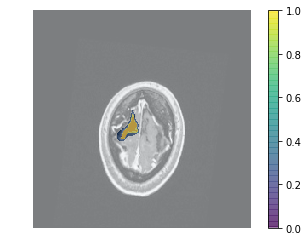

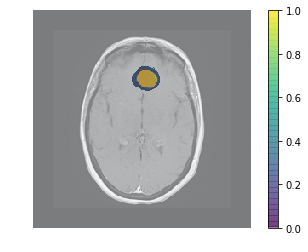

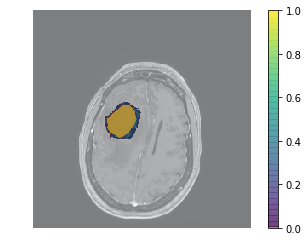

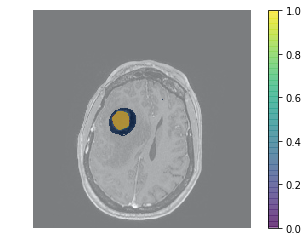

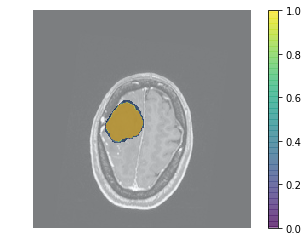

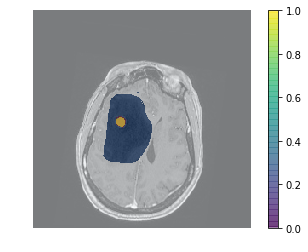

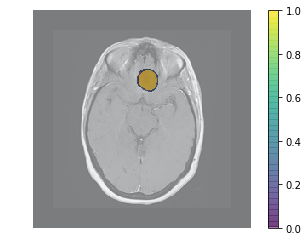

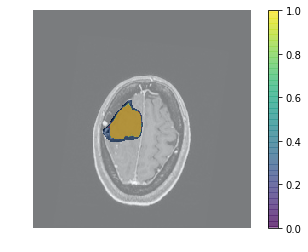

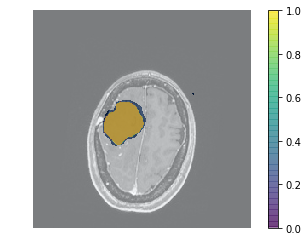

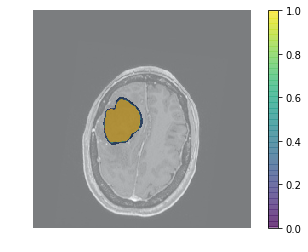

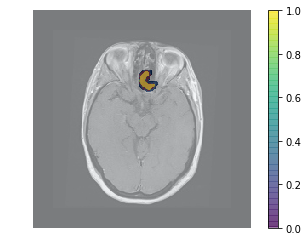

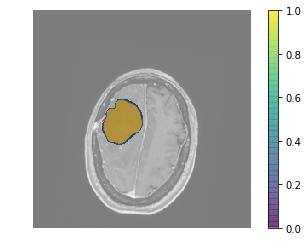

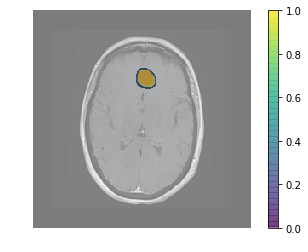

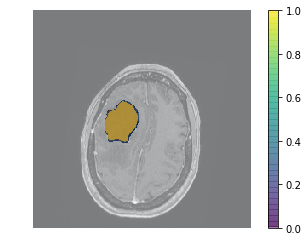

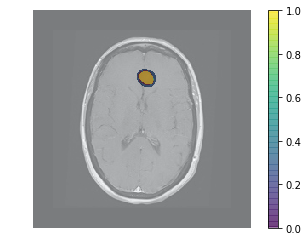

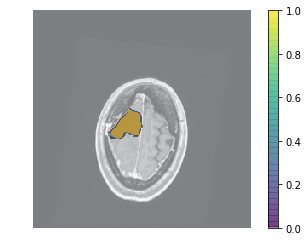

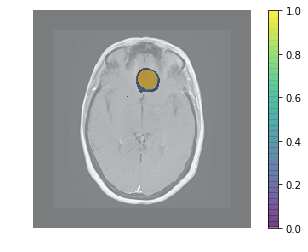

In [44]:
%matplotlib inline
for i in range(x_test.shape[0]):
    plt.figure(i)
    plt.imshow(x_test[i,:,:,0].reshape(256,256), cmap=plt.cm.Greys_r)
    
    hint = x_test[i,:,:,1].reshape(256,256)
    hint[hint==0] = np.nan
    plt.imshow(hint, cmap=plt.cm.Blues, vmin=0, vmax=1, alpha=0.5)
    
    truth = y_test[i,:,:,0].reshape(256,256)
    truth[truth==0] = np.nan
    plt.imshow(truth, cmap=plt.cm.Reds, vmin=0, vmax=1, alpha=0.5)
    
    roi = y_pred[i,:,:,0].reshape(256,256)
    roi[roi<0.5] = np.nan
    plt.imshow(roi, alpha=0.5, vmin=0, vmax=1)
    plt.axis("off")
    plt.colorbar()

In [45]:
len(subjects)

23

In [ ]:
for i in range(x_test.shape[0]):
    plt.figure(i)
    plt.imshow(x_test[i,:,:,0].reshape(256,256), cmap=plt.cm.Greys_r)
    
    #hint = x_test[i,:,:,1].reshape(256,256)
    #hint[hint==0] = np.nan
    #plt.imshow(hint, cmap=plt.cm.Blues, vmin=0, vmax=1, alpha=0.5)
    
    truth = y_test[i,:,:,0].reshape(256,256)
    truth[truth==0] = np.nan
    plt.imshow(truth, cmap=plt.cm.Reds, vmin=0, vmax=1, alpha=0.5)
    
    roi = y_pred_no_hint[i,:,:,0].reshape(256,256)
    roi[roi<0.5] = np.nan
    plt.imshow(roi, alpha=0.5, vmin=0, vmax=1)
    plt.axis("off")
    plt.colorbar()

# run tensorboard

```bash
tensorboard --log ./logs
```

## TODOS:

* standardization
* add "hint" channel but smooth first
* bug satra to give more data